In [2]:
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.framework.ops import EagerTensor
from tensorflow.python.ops.resource_variable_ops import ResourceVariable
import time
!pip install keras-metrics
!pip install scikit-plot
!pip install scipy
import pandas as pd
import re
import nltk
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from tqdm import tqdm
import pickle
from collections import Counter
import operator
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.preprocessing import sequence
from keras.layers import Dropout
from IPython.display import display
import keras_metrics
import keras
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
#import scikitplot as skplt
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
total_data = pd.read_csv("/content/drive/My Drive/cs230 project self/facts_opinions.csv")
total_data.head()

,Text,Label
0,One of the other reviewers has mentioned that ...,0
1,A wonderful little production. <br /><br />The...,0
2,I thought this was a wonderful way to spend ti...,0
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",0


In [5]:
def preproc(data):
  stopword=""
  cleantext = " "
  stopword = set(stopwords.words('english'))
  for i in word_tokenize(data):
    if(any(j.isdigit() for j in i)):
      continue
    i=i.lower()
    if (i not in stopword) and (len(i)>2):
      pattern1 = '[!.?$/\}#=<>"\*:,|_~;()^\']'
      pattern2 = '[\n\n]+'
      pattern3 = '[\ \ ]+'
      wout_sc = re.sub(pattern1,'',i)
      wout_el = re.sub(pattern2,'\n',wout_sc)
      wout_mspaces = re.sub(pattern3,' ',wout_el)
      cleaned_text = wout_mspaces.strip()
      cleaned_text=lemmatizer.lemmatize(cleaned_text)
      if (i not in stopword) and (len(i)>2):
        cleantext = cleantext+cleaned_text+" "
  return cleantext.strip()

In [6]:
for i in tqdm(range(len(total_data)),leave=True,position=0):
  total_data.iloc[i,0] = preproc(total_data.iloc[i,0])

100%|██████████| 94379/94379 [05:12<00:00, 301.62it/s]


In [7]:
pickle_file_path = "/content/drive/My Drive/cs230 project self/facts_opinions.pkl"
total_data.to_pickle(pickle_file_path)

In [8]:
total_data.head()

,Text,Label
0,one reviewer mentioned watching episode ll hoo...,0
1,wonderful little production filming technique ...,0
2,thought wonderful way spend time hot summer we...,0
3,basically family little boy jake think zombie ...,0
4,petter mattei love time money visually stunnin...,0


In [9]:
data_y = pd.DataFrame(data=total_data['Label'],columns=['Label'])
data_x = total_data.drop(columns="Label")

In [10]:
x_train,x_test,y_train,y_test = train_test_split(data_x,data_y,train_size=0.9,random_state=42)
x_train,x_cv,y_train,y_cv = train_test_split(x_train,y_train,train_size=0.9,random_state=42)

In [11]:
x_test.to_csv("/content/drive/My Drive/cs230 project self/x_test.csv",index=False)
y_test.to_csv("/content/drive/My Drive/cs230 project self/y_test.csv",index=False)

In [12]:
max_len=0
l=[]
index=[]
for i in range(len(x_train)):
  cur_len = len(x_train.iloc[i,0].split())
  if(cur_len>max_len):
    max_len=cur_len
print("Maximum length of sentence::",max_len)

Maximum length of sentence:: 1393


In [13]:
vocab={}
for i in tqdm(x_train['Text'],position=0,leave=True):
  for j in i.split():
    if j not in vocab:
      vocab[j]=1
    else:
      vocab[j]+=1
vocab = sorted(vocab, key=vocab.get, reverse=True)

100%|██████████| 76446/76446 [00:02<00:00, 28487.48it/s]


In [14]:
def vectorize(data,vocab):
  print("\nGenerating Vectors......")
  max_seq_len=1400
  row=0
  ## converting sequence to vector...
  new_data = pd.DataFrame(columns=["Text"])
  for i in tqdm(data['Text'],position=0,leave=True):
    sent=[]
    for j in i.split():
      try:
        sent.append((vocab.index(j))+1)
      except:
        continue
    new_data.loc[row] = [sent]
    row+=1
  new_data = sequence.pad_sequences(new_data['Text'], maxlen=max_seq_len)
  return new_data

In [15]:
x_train_vec = vectorize(x_train,vocab)
x_cv_vec = vectorize(x_cv,vocab)
x_test_vec = vectorize(x_test,vocab)


Generating Vectors......


100%|██████████| 76446/76446 [21:31<00:00, 59.19it/s]



Generating Vectors......


100%|██████████| 8495/8495 [02:48<00:00, 50.45it/s]



Generating Vectors......


100%|██████████| 9438/9438 [03:04<00:00, 51.19it/s]


In [16]:
import json
# Basic LSTM model with 0.01 learn rate and 1000 batch size
lstm_model1 = Sequential()
lstm_model1.add(Embedding(1+len(vocab),20,input_length=1400))
lstm_model1.add(LSTM(20))
lstm_model1.add(Dense(2, activation='softmax'))
checkpoint1 = ModelCheckpoint('/content/drive/My Drive/cs230 project self/saved models/model1analysis-{epoch:03d}-{acc:03f}-{val_acc:03f}.keras', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
lstm_model1.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(0.01), metrics=['acc'])
values1analysis=lstm_model1.fit(x_train_vec,keras.utils.to_categorical(y_train,num_classes=2),epochs=3,batch_size=1000,validation_data=(x_cv_vec,keras.utils.to_categorical(y_cv,num_classes=2)),callbacks=[checkpoint1])
with open('/content/drive/My Drive/cs230 project self/saved models/lstm_model1analysis_history.json', 'w') as f:
    json.dump(values1analysis.history, f)

Epoch 1/3
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - acc: 0.8957 - loss: 0.2604
Epoch 1: val_loss improved from inf to 0.04886, saving model to /content/drive/My Drive/cs230 project self/saved models/model1analysis-001-0.956283-0.985050.keras
77/77 ━━━━━━━━━━━━━━━━━━━━ 253s 3s/step - acc: 0.8965 - loss: 0.2587 - val_acc: 0.9851 - val_loss: 0.0489
Epoch 2/3
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - acc: 0.9926 - loss: 0.0288
Epoch 2: val_loss improved from 0.04886 to 0.04323, saving model to /content/drive/My Drive/cs230 project self/saved models/model1analysis-002-0.992426-0.987051.keras
77/77 ━━━━━━━━━━━━━━━━━━━━ 262s 3s/step - acc: 0.9926 - loss: 0.0288 - val_acc: 0.9871 - val_loss: 0.0432
Epoch 3/3
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - acc: 0.9976 - loss: 0.0109
Epoch 3: val_loss did not improve from 0.04323
77/77 ━━━━━━━━━━━━━━━━━━━━ 260s 3s/step - acc: 0.9976 - loss: 0.0109 - val_acc: 0.9876 - val_loss: 0.0465


In [37]:
from sklearn.feature_extraction.text import CountVectorizer
# Assuming data_x['Text'] contains the original texts and y_cv contains the actual labels
# predictions is the list of predicted labels

predictions_prob = lstm_model1.predict(x_cv_vec)

# Convert probabilities to class labels (assuming binary classification)
predictions = np.argmax(predictions_prob, axis=1)

true_labels = y_cv.values

# Identify misclassified indices
misclassified_indices = [
    i for i in range(len(x_cv)) if predictions[i] != true_labels[i]
]

# Extract the original texts for misclassified examples
misclassified_texts = data_x.iloc[misclassified_indices]['Text']

# Perform n-gram analysis
def ngram_analysis(texts, n=2):
    """
    Analyze the most common n-grams in the given texts.
    Args:
        texts (iterable): Collection of text data.
        n (int): The size of n-grams to analyze.
    Returns:
        DataFrame: Most common n-grams with their counts.
    """
    vectorizer = CountVectorizer(ngram_range=(n, n), max_features=20, stop_words='english')
    X = vectorizer.fit_transform(texts)
    ngram_counts = X.sum(axis=0).A1
    ngram_features = vectorizer.get_feature_names_out()

    # Create a DataFrame of n-grams and their counts
    ngram_df = pd.DataFrame({
        'N-gram': ngram_features,
        'Count': ngram_counts
    }).sort_values(by='Count', ascending=False)

    return ngram_df

# Run unigram analysis (change `n` for other n-grams)
unigram_df = ngram_analysis(misclassified_texts, n=1)
sorted_unigram_df = unigram_df.sort_values(by='Count', ascending=False).reset_index(drop=True)
print("Most common unigrams in misclassified examples:")
print(sorted_unigram_df)

# Example: Save results to a CSV file
unigram_df.to_csv('/content/drive/My Drive/ngram_analysis_unigrams.csv', index=False)


# Run bigram analysis (change `n` for other n-grams)
bigram_df = ngram_analysis(misclassified_texts, n=2)
sorted_bigram_df = bigram_df.sort_values(by='Count', ascending=False).reset_index(drop=True)
print("Most common bigrams in misclassified examples:")
print(sorted_bigram_df)

# Example: Save results to a CSV file
bigram_df.to_csv('/content/drive/My Drive/ngram_analysis_bigrams.csv', index=False)

# Optional: Trigram analysis
trigram_df = ngram_analysis(misclassified_texts, n=3)
sorted_trigram_df = trigram_df.sort_values(by='Count', ascending=False).reset_index(drop=True)
print("Most common trigrams in misclassified examples:")
print(sorted_trigram_df)

# Save trigram results
trigram_df.to_csv('/content/drive/My Drive/ngram_analysis_trigrams.csv', index=False)


266/266 ━━━━━━━━━━━━━━━━━━━━ 29s 111ms/step
Most common unigrams in misclassified examples:
       N-gram  Count
0       movie    189
1        film    181
2          nt    119
3        like     77
4       story     68
5        good     65
6        time     59
7       thing     48
8         bad     45
9   character     44
10      scene     44
11       make     41
12        end     39
13     really     37
14     better     35
15       look     31
16       best     31
17     people     31
18        say     30
19     little     29
Most common bigrams in misclassified examples:
             N-gram  Count
0   barry champlain     11
1           ve seen     10
2          bug life      9
3    special effect      7
4          movie nt      6
5       pretty good      6
6       jesus jesus      6
7         look like      6
8           film nt      5
9       worst movie      5
10        end movie      5
11          bad guy      5
12          nt know      5
13      people like      5
14         ll l

266/266 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step


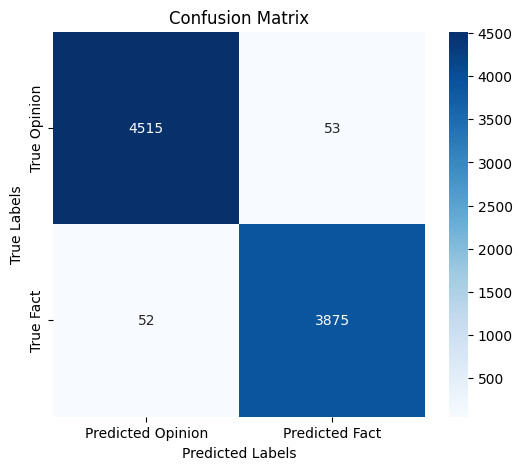

In [42]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Step 1: Make predictions on the validation data
predictions_prob = lstm_model1.predict(x_cv_vec)

# Step 2: Convert probabilities to class labels (assuming binary classification)
predictions = np.argmax(predictions_prob, axis=1)

# Step 3: Ensure y_cv is in the correct format
# If y_cv is one-hot encoded, convert it to class labels
true_labels = y_cv.values

# Step 4: Generate the confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Step 5: Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Opinion', 'Predicted Fact'], yticklabels=['True Opinion', 'True Fact'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [43]:
# add 2-3 different models for comparison and show a couple of wrongly classified examples
bi_lstm_model = Sequential()
bi_lstm_model.add(Embedding(1 + len(vocab), 20, input_length=1400))
bi_lstm_model.add(Bidirectional(LSTM(20)))
bi_lstm_model.add(Dense(2, activation='softmax'))

checkpoint1 = ModelCheckpoint('/content/drive/My Drive/cs230 project self/saved models/bi_model_lstm-{epoch:03d}-{acc:03f}-{val_acc:03f}.keras', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
bi_lstm_model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(0.01), metrics=['acc'])


values_bi=bi_lstm_model.fit(x_train_vec,keras.utils.to_categorical(y_train,num_classes=2),epochs=3,batch_size=1000,validation_data=(x_cv_vec,keras.utils.to_categorical(y_cv,num_classes=2)),callbacks=[checkpoint1])
with open('/content/drive/My Drive/cs230 project self/saved models/bi_lstm_model_history.json', 'w') as f:
    json.dump(values_bi.history, f)

Epoch 1/3
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - acc: 0.8767 - loss: 0.2942
Epoch 1: val_loss improved from inf to 0.04444, saving model to /content/drive/My Drive/cs230 project self/saved models/bi_model_lstm-001-0.950501-0.987404.keras
77/77 ━━━━━━━━━━━━━━━━━━━━ 610s 8s/step - acc: 0.8777 - loss: 0.2924 - val_acc: 0.9874 - val_loss: 0.0444
Epoch 2/3
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - acc: 0.9918 - loss: 0.0296
Epoch 2: val_loss did not improve from 0.04444
77/77 ━━━━━━━━━━━━━━━━━━━━ 486s 6s/step - acc: 0.9918 - loss: 0.0296 - val_acc: 0.9861 - val_loss: 0.0476
Epoch 3/3
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - acc: 0.9977 - loss: 0.0108
Epoch 3: val_loss did not improve from 0.04444
77/77 ━━━━━━━━━━━━━━━━━━━━ 506s 6s/step - acc: 0.9977 - loss: 0.0109 - val_acc: 0.9872 - val_loss: 0.0448


In [44]:
stack_lstm_model = Sequential()
stack_lstm_model.add(Embedding(1 + len(vocab), 20, input_length=1400))
stack_lstm_model.add(LSTM(50, return_sequences=True))
stack_lstm_model.add(LSTM(20))
stack_lstm_model.add(Dense(2, activation='softmax'))

checkpoint1 = ModelCheckpoint('/content/drive/My Drive/cs230 project self/saved models/stack_model_lstm-{epoch:03d}-{acc:03f}-{val_acc:03f}.keras', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')

stack_lstm_model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(0.01), metrics=['acc'])

values_stack=stack_lstm_model.fit(x_train_vec,keras.utils.to_categorical(y_train,num_classes=2),epochs=3,batch_size=1000,validation_data=(x_cv_vec,keras.utils.to_categorical(y_cv,num_classes=2)),callbacks=[checkpoint1])
with open('/content/drive/My Drive/cs230 project self/saved models/stack_lstm_model_history.json', 'w') as f:
    json.dump(values_stack.history, f)

Epoch 1/3
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - acc: 0.8933 - loss: 0.2683 
Epoch 1: val_loss improved from inf to 0.04157, saving model to /content/drive/My Drive/cs230 project self/saved models/stack_model_lstm-001-0.953994-0.986698.keras
77/77 ━━━━━━━━━━━━━━━━━━━━ 884s 11s/step - acc: 0.8940 - loss: 0.2666 - val_acc: 0.9867 - val_loss: 0.0416
Epoch 2/3
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - acc: 0.9930 - loss: 0.0259 
Epoch 2: val_loss improved from 0.04157 to 0.03751, saving model to /content/drive/My Drive/cs230 project self/saved models/stack_model_lstm-002-0.993486-0.988111.keras
77/77 ━━━━━━━━━━━━━━━━━━━━ 906s 11s/step - acc: 0.9930 - loss: 0.0258 - val_acc: 0.9881 - val_loss: 0.0375
Epoch 3/3
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - acc: 0.9982 - loss: 0.0088 
Epoch 3: val_loss did not improve from 0.03751
77/77 ━━━━━━━━━━━━━━━━━━━━ 916s 11s/step - acc: 0.9982 - loss: 0.0088 - val_acc: 0.9866 - val_loss: 0.0441


In [45]:
drop_lstm_model = Sequential()
drop_lstm_model.add(Embedding(1+len(vocab),20,input_length=1400))
drop_lstm_model.add(LSTM(20, dropout=0.2, recurrent_dropout=0.2))
drop_lstm_model.add(Dense(2, activation='softmax'))

checkpoint1 = ModelCheckpoint('/content/drive/My Drive/cs230 project self/saved models/drop_lstm_model-{epoch:03d}-{acc:03f}-{val_acc:03f}.keras', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
drop_lstm_model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(0.01), metrics=['acc'])
values_drop=drop_lstm_model.fit(x_train_vec,keras.utils.to_categorical(y_train,num_classes=2),epochs=3,batch_size=1000,validation_data=(x_cv_vec,keras.utils.to_categorical(y_cv,num_classes=2)),callbacks=[checkpoint1])
with open('/content/drive/My Drive/cs230 project self/saved models/drop_lstm_history.json', 'w') as f:
    json.dump(values1analysis.history, f)

Epoch 1/3
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - acc: 0.8746 - loss: 0.3068
Epoch 1: val_loss improved from inf to 0.05059, saving model to /content/drive/My Drive/cs230 project self/saved models/drop_lstm_model-001-0.946328-0.984108.keras
77/77 ━━━━━━━━━━━━━━━━━━━━ 273s 3s/step - acc: 0.8755 - loss: 0.3049 - val_acc: 0.9841 - val_loss: 0.0506
Epoch 2/3
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - acc: 0.9881 - loss: 0.0392
Epoch 2: val_loss did not improve from 0.05059
77/77 ━━━━━━━━━━━━━━━━━━━━ 324s 4s/step - acc: 0.9881 - loss: 0.0392 - val_acc: 0.9828 - val_loss: 0.0525
Epoch 3/3
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - acc: 0.9947 - loss: 0.0197
Epoch 3: val_loss improved from 0.05059 to 0.04911, saving model to /content/drive/My Drive/cs230 project self/saved models/drop_lstm_model-003-0.994754-0.985639.keras
77/77 ━━━━━━━━━━━━━━━━━━━━ 272s 4s/step - acc: 0.9947 - loss: 0.0197 - val_acc: 0.9856 - val_loss: 0.0491


In [54]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
y_pred_prob = lstm_model1.predict(x_cv_vec)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = y_cv


accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)


print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Validation Precision: {precision:.4f}")
print(f"Validation Recall: {recall:.4f}")
print(f"Validation F1 Score: {f1:.4f}")

266/266 ━━━━━━━━━━━━━━━━━━━━ 30s 112ms/step
Validation Accuracy: 0.9876
Validation Precision: 0.9865
Validation Recall: 0.9868
Validation F1 Score: 0.9866


In [55]:
y_pred_prob = bi_lstm_model.predict(x_cv_vec)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = y_cv


accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)


print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Validation Precision: {precision:.4f}")
print(f"Validation Recall: {recall:.4f}")
print(f"Validation F1 Score: {f1:.4f}")

266/266 ━━━━━━━━━━━━━━━━━━━━ 45s 169ms/step
Validation Accuracy: 0.9872
Validation Precision: 0.9858
Validation Recall: 0.9865
Validation F1 Score: 0.9861


In [56]:
y_pred_prob = stack_lstm_model.predict(x_cv_vec)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = y_cv


accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)


print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Validation Precision: {precision:.4f}")
print(f"Validation Recall: {recall:.4f}")
print(f"Validation F1 Score: {f1:.4f}")

266/266 ━━━━━━━━━━━━━━━━━━━━ 68s 256ms/step
Validation Accuracy: 0.9866
Validation Precision: 0.9872
Validation Recall: 0.9837
Validation F1 Score: 0.9855


In [57]:
y_pred_prob = drop_lstm_model.predict(x_cv_vec)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = y_cv


accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)


print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Validation Precision: {precision:.4f}")
print(f"Validation Recall: {recall:.4f}")
print(f"Validation F1 Score: {f1:.4f}")

266/266 ━━━━━━━━━━━━━━━━━━━━ 30s 111ms/step
Validation Accuracy: 0.9856
Validation Precision: 0.9808
Validation Recall: 0.9883
Validation F1 Score: 0.9845
